In [3]:
import pickle
import pandas as pd
import json 
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import cv2
import numpy as np

SHOULD_REBUILD = True
IMG_PATH_DIR = '../'
PREPROCESSED_FORM_IMG_PATH = 'augmented_form_imgs/'
FORM_IMG_SIZE = (3542, 2479)

In [10]:
def get_preprocessed_form_img_path_from_id(form_id):
    return PREPROCESSED_FORM_IMG_PATH + form_id + '.png'

df = pd.read_pickle('../../pickle/df.pickle')
df['form_img_path'] = '../' + df['form_img_path_y']
df = df.drop(columns=['form_img_path_y'])
bad_df = df[df['total_words'] != df['correct_words']]
df = df[df['total_words'] == df['correct_words']]
df.head()

,index,word_id,gray_level,x,y,w,h,tag,transcription,word_img_path,...,form_id,writer_id,text_id,number_of_sentences,word_seg,total_lines,correct_lines,total_words,correct_words,form_img_path
36,52,a01-000x-00-00,182,375,767,35,67,AT,A,../data/words/a01/a01-000x/a01-000x-00-00.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
37,53,a01-000x-00-01,182,506,763,143,66,NN,MOVE,../data/words/a01/a01-000x/a01-000x-00-01.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
38,54,a01-000x-00-02,182,730,760,44,70,TO,to,../data/words/a01/a01-000x/a01-000x-00-02.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
39,55,a01-000x-00-03,182,832,764,89,114,VB,stop,../data/words/a01/a01-000x/a01-000x-00-03.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
40,56,a01-000x-00-04,182,1001,760,84,71,NPT,Mr.,../data/words/a01/a01-000x/a01-000x-00-04.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png


# Utility

In [12]:
import tensorflow_addons as tfa
import math 

@tf.function
def load_image(filepath, resize=None):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)
    if resize:
        return tf.image.resize(im, resize)
    return im

@tf.function
def rotate_fixed_size_image(img, rotation_deg):
    img_original_size = tf.shape(img)
    # Add padding to later rotate without losing info
    padding_scale = abs(rotation_deg / 100)  
    dx = int(padding_scale * float(img_original_size[1]))
    dy = int(padding_scale * float(img_original_size[0]))
    # top, bottom, left, right
    img = tf.pad(img[..., 0], [[dx, dx], [dy, dy]], constant_values=1)

    # Rotate 
    img = tfa.image.rotate(img, rotation_deg * math.pi / 180, fill_value=1.0)

    # Resize
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.resize(img, (int(img_original_size[0]), int(img_original_size[1])))
    return img



In [15]:
def get_formated_db_coords_from_df(df):
    coords = []
    for index, row in df.iterrows():
        coords.append([
            [row.x, row.y],
            [row.x + row.w, row.y],
            [row.x + row.w, row.y + row.h],
            [row.x, row.y + row.h],
        ])
    return coords

In [16]:
from doctr.models import ocr_predictor
from doctr.io import DocumentFile


def format_doctr_coords(img_detection_result, size = (1,1)):
    ''' 
    Return the scaled coordinates as an array of 4-point arrays 
    https://mindee.github.io/doctr/modules/io.html#block
    '''
    height = size[0]
    width = size[1]

    trans_coords = []
    for arr in img_detection_result:
        xmin = arr[0]
        ymin = arr[1]
        xmax = arr[2]
        ymax = arr[3]

        trans_coords.append(
            [
                [xmin * width, ymin * height], #xmin #ymin
                [xmax * width, ymin * height], #xmax #ymin
                [xmax * width, ymax * height], #xmax #ymax
                [xmin * width, ymax * height], #xmin #ymax
        ]
    )
    return trans_coords

/Users/jpec/miniconda3/envs/work/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:

@tf.function
def preprocess_img_and_coords(img, polygons, img_size=FORM_IMG_SIZE, threshold = 0.8):
    img_original_size = tf.shape(img)    

    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = tf.ones([img_size[0], img_size[1], 1])
        res = tf.expand_dims(img, -1)
        return res
    
    # if with_rotation:
    #     rotation_deg = int(np.random.normal() * 25)
    #     img = rotate_fixed_size_image(img, rotation_deg)

    # increase dataset size by applying random stretches to the images
    stretch = (1 + 0.8 * (tf.random.uniform([1], 0, 1)[0] - 0.3))
    w_stretched = tf.maximum(int(float(img_original_size[0]) * stretch), 1) # random width, but at least 1
    img = tf.image.resize(img, (w_stretched, img_original_size[1])) # stretch horizontally by factor 0.5 .. 1.5
    
    # COORDS
    width_stretch_ratio = int(w_stretched / img_original_size[0])
    # END COORDS
    
    # Rescale
    # create target image and copy sample image into it
    (wt, ht) = img_size
    w, h = float(tf.shape(img)[0]), float(tf.shape(img)[1])
    fx = w / wt
    fy = h / ht
    f = tf.maximum(fx, fy)
    newSize = (tf.maximum(tf.minimum(wt, int(w / f)), 1), tf.maximum(tf.minimum(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = tf.image.resize(img, newSize)
    # COORDS
    width_stretch_ratio_2 = int(newSize[0] / wt)
    height_stretch_ratio_2 = int(newSize[1] / ht)
    # END COORDS

    # Add padding
    dx = wt - newSize[0]
    dy = ht - newSize[1]
    dx1=0
    dy1=0
    if dx != 0:
        dx1 = tf.random.uniform([1], 0, dx, tf.int32)[0]
    if dy != 0:
        dy1 = tf.random.uniform([1], 0, dy, tf.int32)[0]
    img = tf.pad(img[..., 0], [[dx1, dx-dx1], [dy1, dy-dy1]], constant_values=1)
    # COORDS
    translate_x = dx1
    translate_y = dy1
    # END COORDS

    # if threshold != None:
    #     img = 1 - (1 - img) * tf.cast(img < threshold, tf.float32)


    for polygon in polygons:
        for point in polygon:
            point[0] = point[0] * width_stretch_ratio 
            point[0] = point[0] * width_stretch_ratio_2 
            point[1] = point[1] * height_stretch_ratio_2 
            point[0] = point[0] + translate_x 
            point[1] = point[1] + translate_y 


    img = tf.expand_dims(img, -1)
    return img, polygons

# TODO

  0%|          | 0/583 [00:00<?, ?it/s]

(3542, 2479, 1)


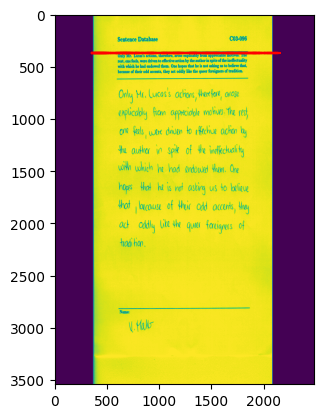

  0%|          | 0/583 [00:00<?, ?it/s]


In [39]:
all_form_paths = list(set(df['form_img_path'].values))
form_count = len(all_form_paths)

original_model = ocr_predictor(
    det_arch = 'db_resnet50',    
    reco_arch = 'crnn_vgg16_bn', 
    pretrained = True
)

for form_img_path in tqdm(all_form_paths, total = form_count):
    # Get corresponding database rows
    form_df = df[df['form_img_path'] == form_img_path]
    form_id = form_df.iloc[0].form_id
    # display(form_df.head(20))

    # Load image
    form_img = load_image(form_img_path)
    form_shape = form_img.shape
    # plt.imshow(form_img)
    # plt.show()

    # Get database coordinates
    db_coords = get_formated_db_coords_from_df(form_df)

    # Get Doctr coordinates
    # doc = DocumentFile.from_images(form_img_path)
    # doctr_coords = format_doctr_coords(original_model.det_predictor(doc)[0])

    # Apply preprocess on form image and coordinates
    modified_img, coordinate_transforms = preprocess_img_and_coords(form_img, db_coords)

    print(modified_img.shape)
    plt.imshow(modified_img)
    for polygon_data in coordinate_transforms:
        x = []
        y = []
        for point in polygon_data:
            x.append(point[0])
            y.append(point[1])
        x.append(polygon_data[0][0])
        y.append(polygon_data[0][1])
        plt.plot(x, y, color='red')

    # plt.plot()
    plt.show()
    

    # Save modified form image and coordinates into dict

    # Check modified form image with modified coordinates
    break
    

In [17]:
from doctr.models import ocr_predictor

DET_CKPT = "straight_model/weights"

straight_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
straight_model.det_predictor.model.load_weights(DET_CKPT)

In [18]:
straight_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
straight_model.det_predictor.model.load_weights(DET_CKPT)
doc = DocumentFile.from_images(form_img_path)
coords = straight_model.det_predictor(doc)